## 12	SIMULACIÓN MONTE CARLO EN FINANZAS

## 12.1	Simulando la dinámica del precio de las acciones utilizando Movimiento browniano geométrico

In [5]:
# 1. Importar librerías

import numpy as np
import pandas as pd
import yfinance as yf

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
# 2. Definir parámetros para descargar datos:

RISKY_ASSET = 'MSFT'
START_DATE = '2019-01-01'
END_DATE = '2019-07-31'

In [9]:
# 3. Descargar los datos de Yahoo Finance:

df = yf.download(RISKY_ASSET, start=START_DATE, 
                 end=END_DATE, adjusted=True)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  1 of 1 completed
Downloaded 145 rows of data.


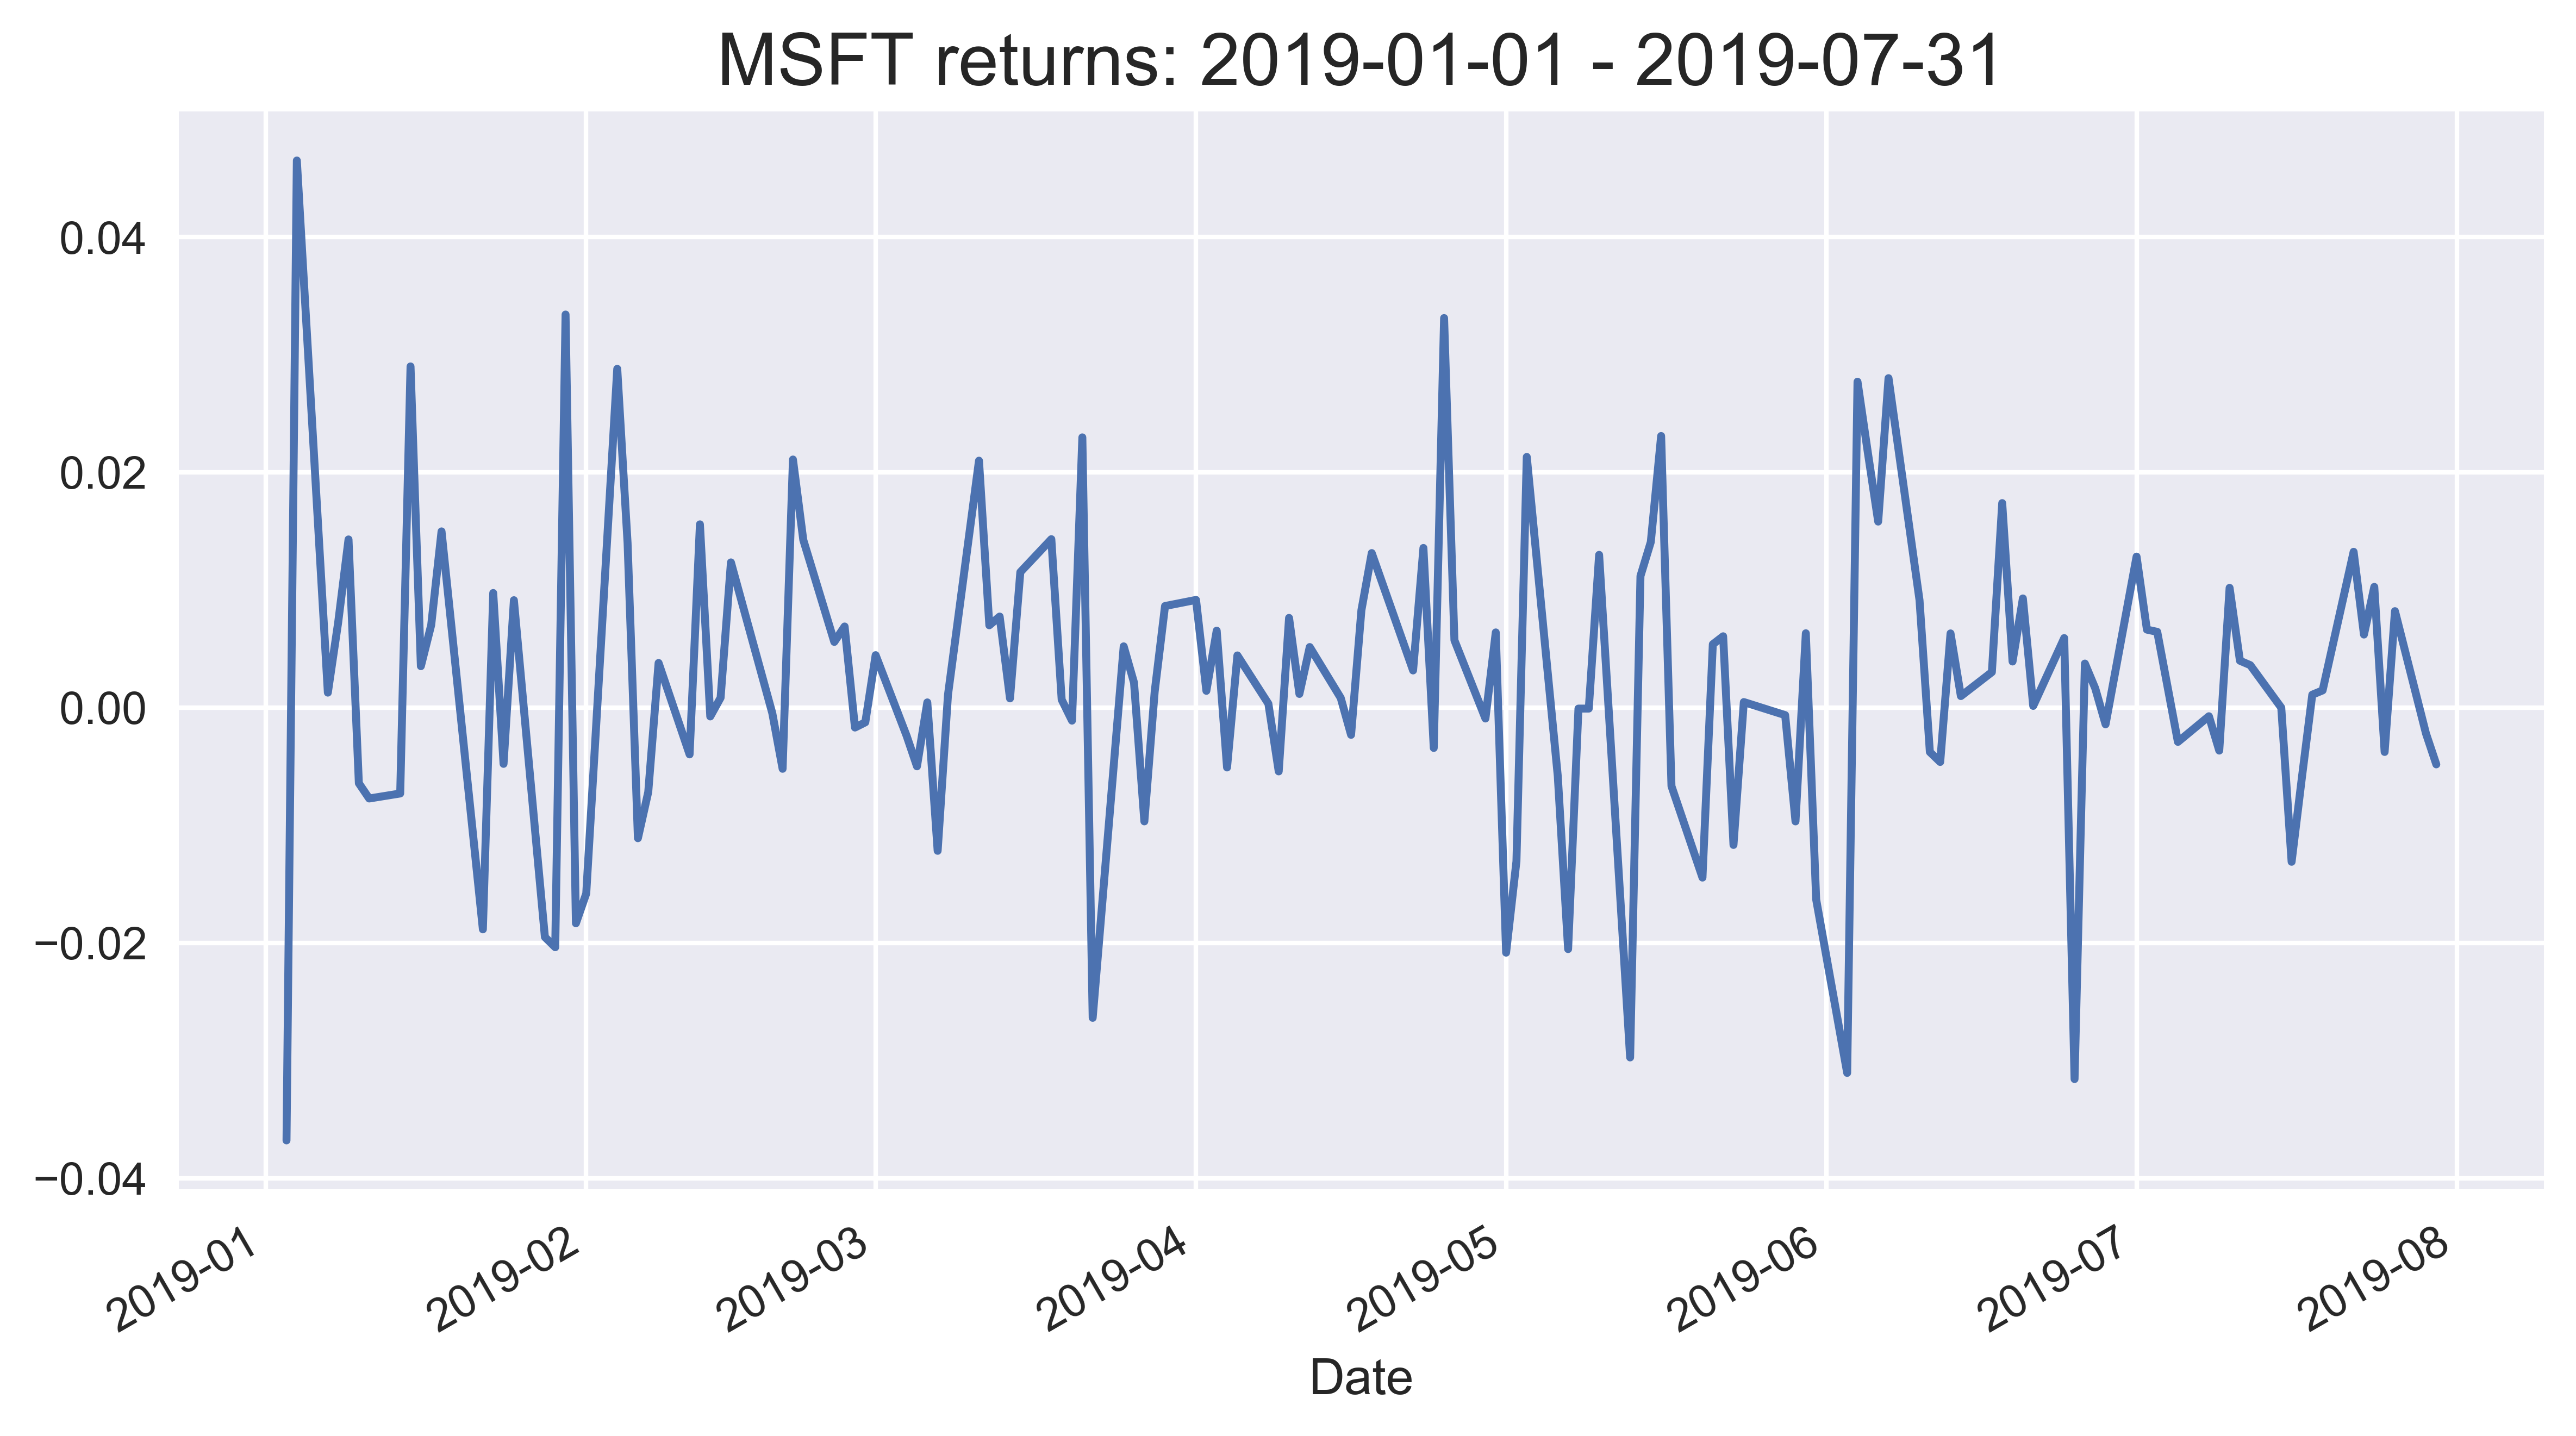

In [10]:
# 4.Calcular los rendimientos diarios

adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()

ax = returns.plot()
ax.set_title(f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}', 
             fontsize=16)

plt.tight_layout()

plt.show()



In [11]:
print(f'Average return: {100 * returns.mean():.2f}%')

Average return: 0.24%


In [12]:
# 5. Divida los datos en conjuntos de entrenamiento y prueba:

train = returns['2019-01-01':'2019-06-30']
test = returns['2019-07-01':'2019-07-31']

In [13]:
# 6. Especifique los parámetros de la simulación:

T = len(test)
N = len(test)
S_0 = adj_close[train.index[-1].date()]
N_SIM = 100
mu = train.mean()
sigma = train.std()

In [14]:
# 7. Defina la función para simulaciones:

def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    np.random.seed(random_seed)
    
    dt = T/N
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps 
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    
    return S_t

In [15]:
# 8. Ejecute las simulaciones:

gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

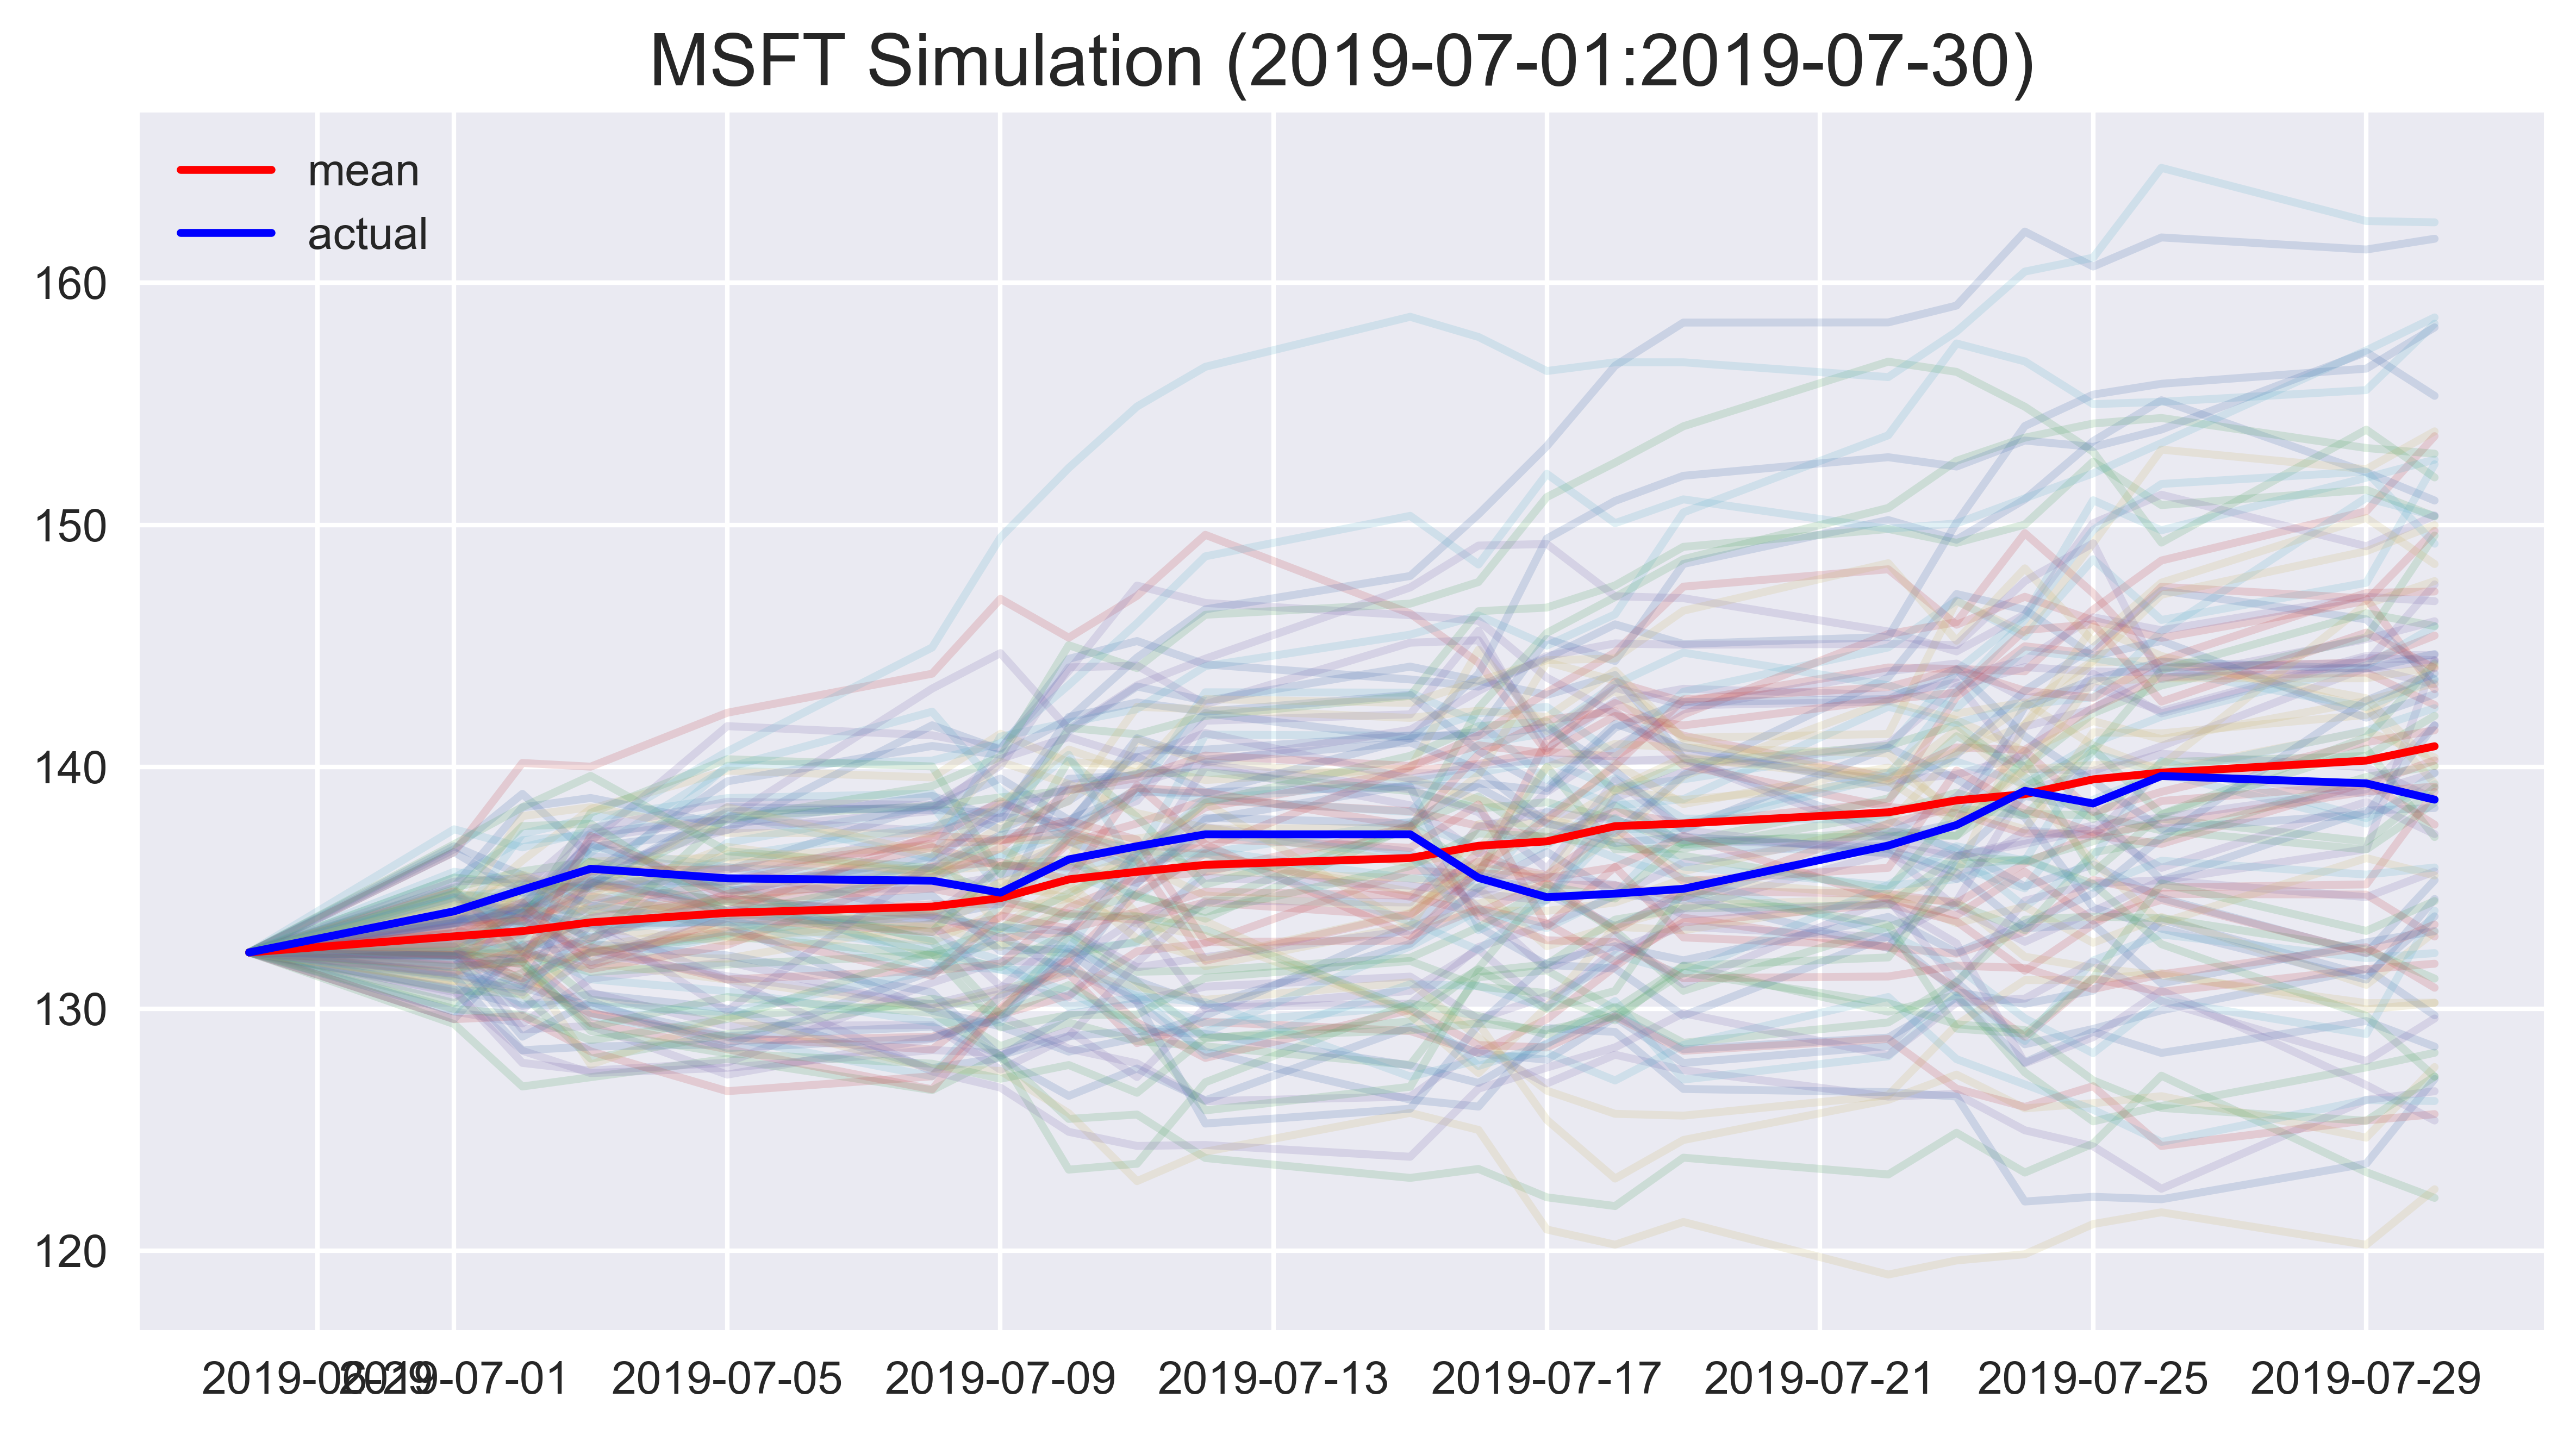

In [16]:
# 9. Graficar resultados de simulación:

# preparar los objetos para graficar

last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                  index=index)

# Graficar 

ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()

plt.show()


## 12.2	Precios de opciones europeas mediante simulaciones

In [18]:
# 1. Importar las librerias

import numpy as np
from scipy.stats import norm


In [19]:
# 2. Defina los parámetros para la valoración:

S_0 = 100
K = 100
r = 0.05
sigma = 0.50
T = 1 # 1 year
N = 252 # 252 days in a year
dt = T / N # time step
N_SIMS = 1000000 # number of simulations 
discount_factor = np.exp(-r * T)

In [20]:
# 3.Defina la función utilizando la solución analítica:

def black_scholes_analytical(S_0, K, T, r, sigma, type='call'):
    '''
    Function used for calculating the price of European options using the analytical form of the Black-Scholes model.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    type : str
        Type of the option. Allowable: ['call', 'put']
    
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using the Black-Scholes model
    '''
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if type == 'call':
        val = (S_0 * norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * norm.cdf(d2, 0, 1))
    elif type == 'put':
        val = (K * np.exp(-r * T) * norm.cdf(-d2, 0, 1) - S_0 * norm.cdf(-d1, 0, 1))
    else:
        raise ValueError('Wrong input for type!')
        
    return val

In [21]:
# 4.Valore la opción de compra utilizando los parámetros especificados:

black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='call')

21.79260421286685

In [22]:
# 5. Simule la ruta del precio de la acción con GBM (movimiento browniango geométrico:

gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, 
                       n_sims=N_SIMS, T=T, N=N)

In [23]:
# 6.Calcule la prima de la opción:

premium = discount_factor * np.mean(np.maximum(0, gbm_sims[:, -1] - K))
premium

21.731937527394578

## 12.3	Estimación del valor en riesgo utilizando Monte Carlo

In [24]:
# 1. Importar librerias

import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns

In [25]:
# 2. Establecer semilla aleatoria para la reproducibilidad

np.random.seed(42)

In [26]:
# 3. Defina los parámetros que se utilizarán para este ejercicio:

RISKY_ASSETS = ['GOOG', 'FB']
SHARES = [5, 5]
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
T = 1
N_SIMS = 10 ** 5

In [27]:
# 4. Descargar datos de Yahoo Finance:

df = yf.download(RISKY_ASSETS, start=START_DATE, 
                 end=END_DATE, adjusted=True)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  2 of 2 completed
Downloaded 250 rows of data.


In [28]:
df.head()

Adj Close                    Close                     High  \
                    FB         GOOG          FB         GOOG          FB   
Date                                                                       
2018-01-02  181.419998  1065.000000  181.419998  1065.000000  181.580002   
2018-01-03  184.669998  1082.479980  184.669998  1082.479980  184.779999   
2018-01-04  184.330002  1086.400024  184.330002  1086.400024  186.210007   
2018-01-05  186.850006  1102.229980  186.850006  1102.229980  186.899994   
2018-01-08  188.279999  1106.939941  188.279999  1106.939941  188.899994   

                                Low                     Open               \
                   GOOG          FB         GOOG          FB         GOOG   
Date                                                                        
2018-01-02  1066.939941  177.550003  1045.229980  177.679993  1048.339966   
2018-01-03  1086.290039  181.330002  1063.209961  181.880005  1064.310059   
2018-01-04  1093.569946  184.100006  1084.001953  184.899994  1088.000000   
2018-01-05  1104.250000  184.929993  1092.000000  185.589996  1094.000000   
2018-01-08  1111.270020  186.330002  1101.619995  187.199997  1102.229980   

              Volume           
                  FB     GOOG  
Date                           
2018-01-02  18151900  1237600  
2018-01-03  16886600  1430200  
2018-01-04  13880900  1004600  
2018-01-05  13574500  1279100  
2018-01-08  17994700  1047600

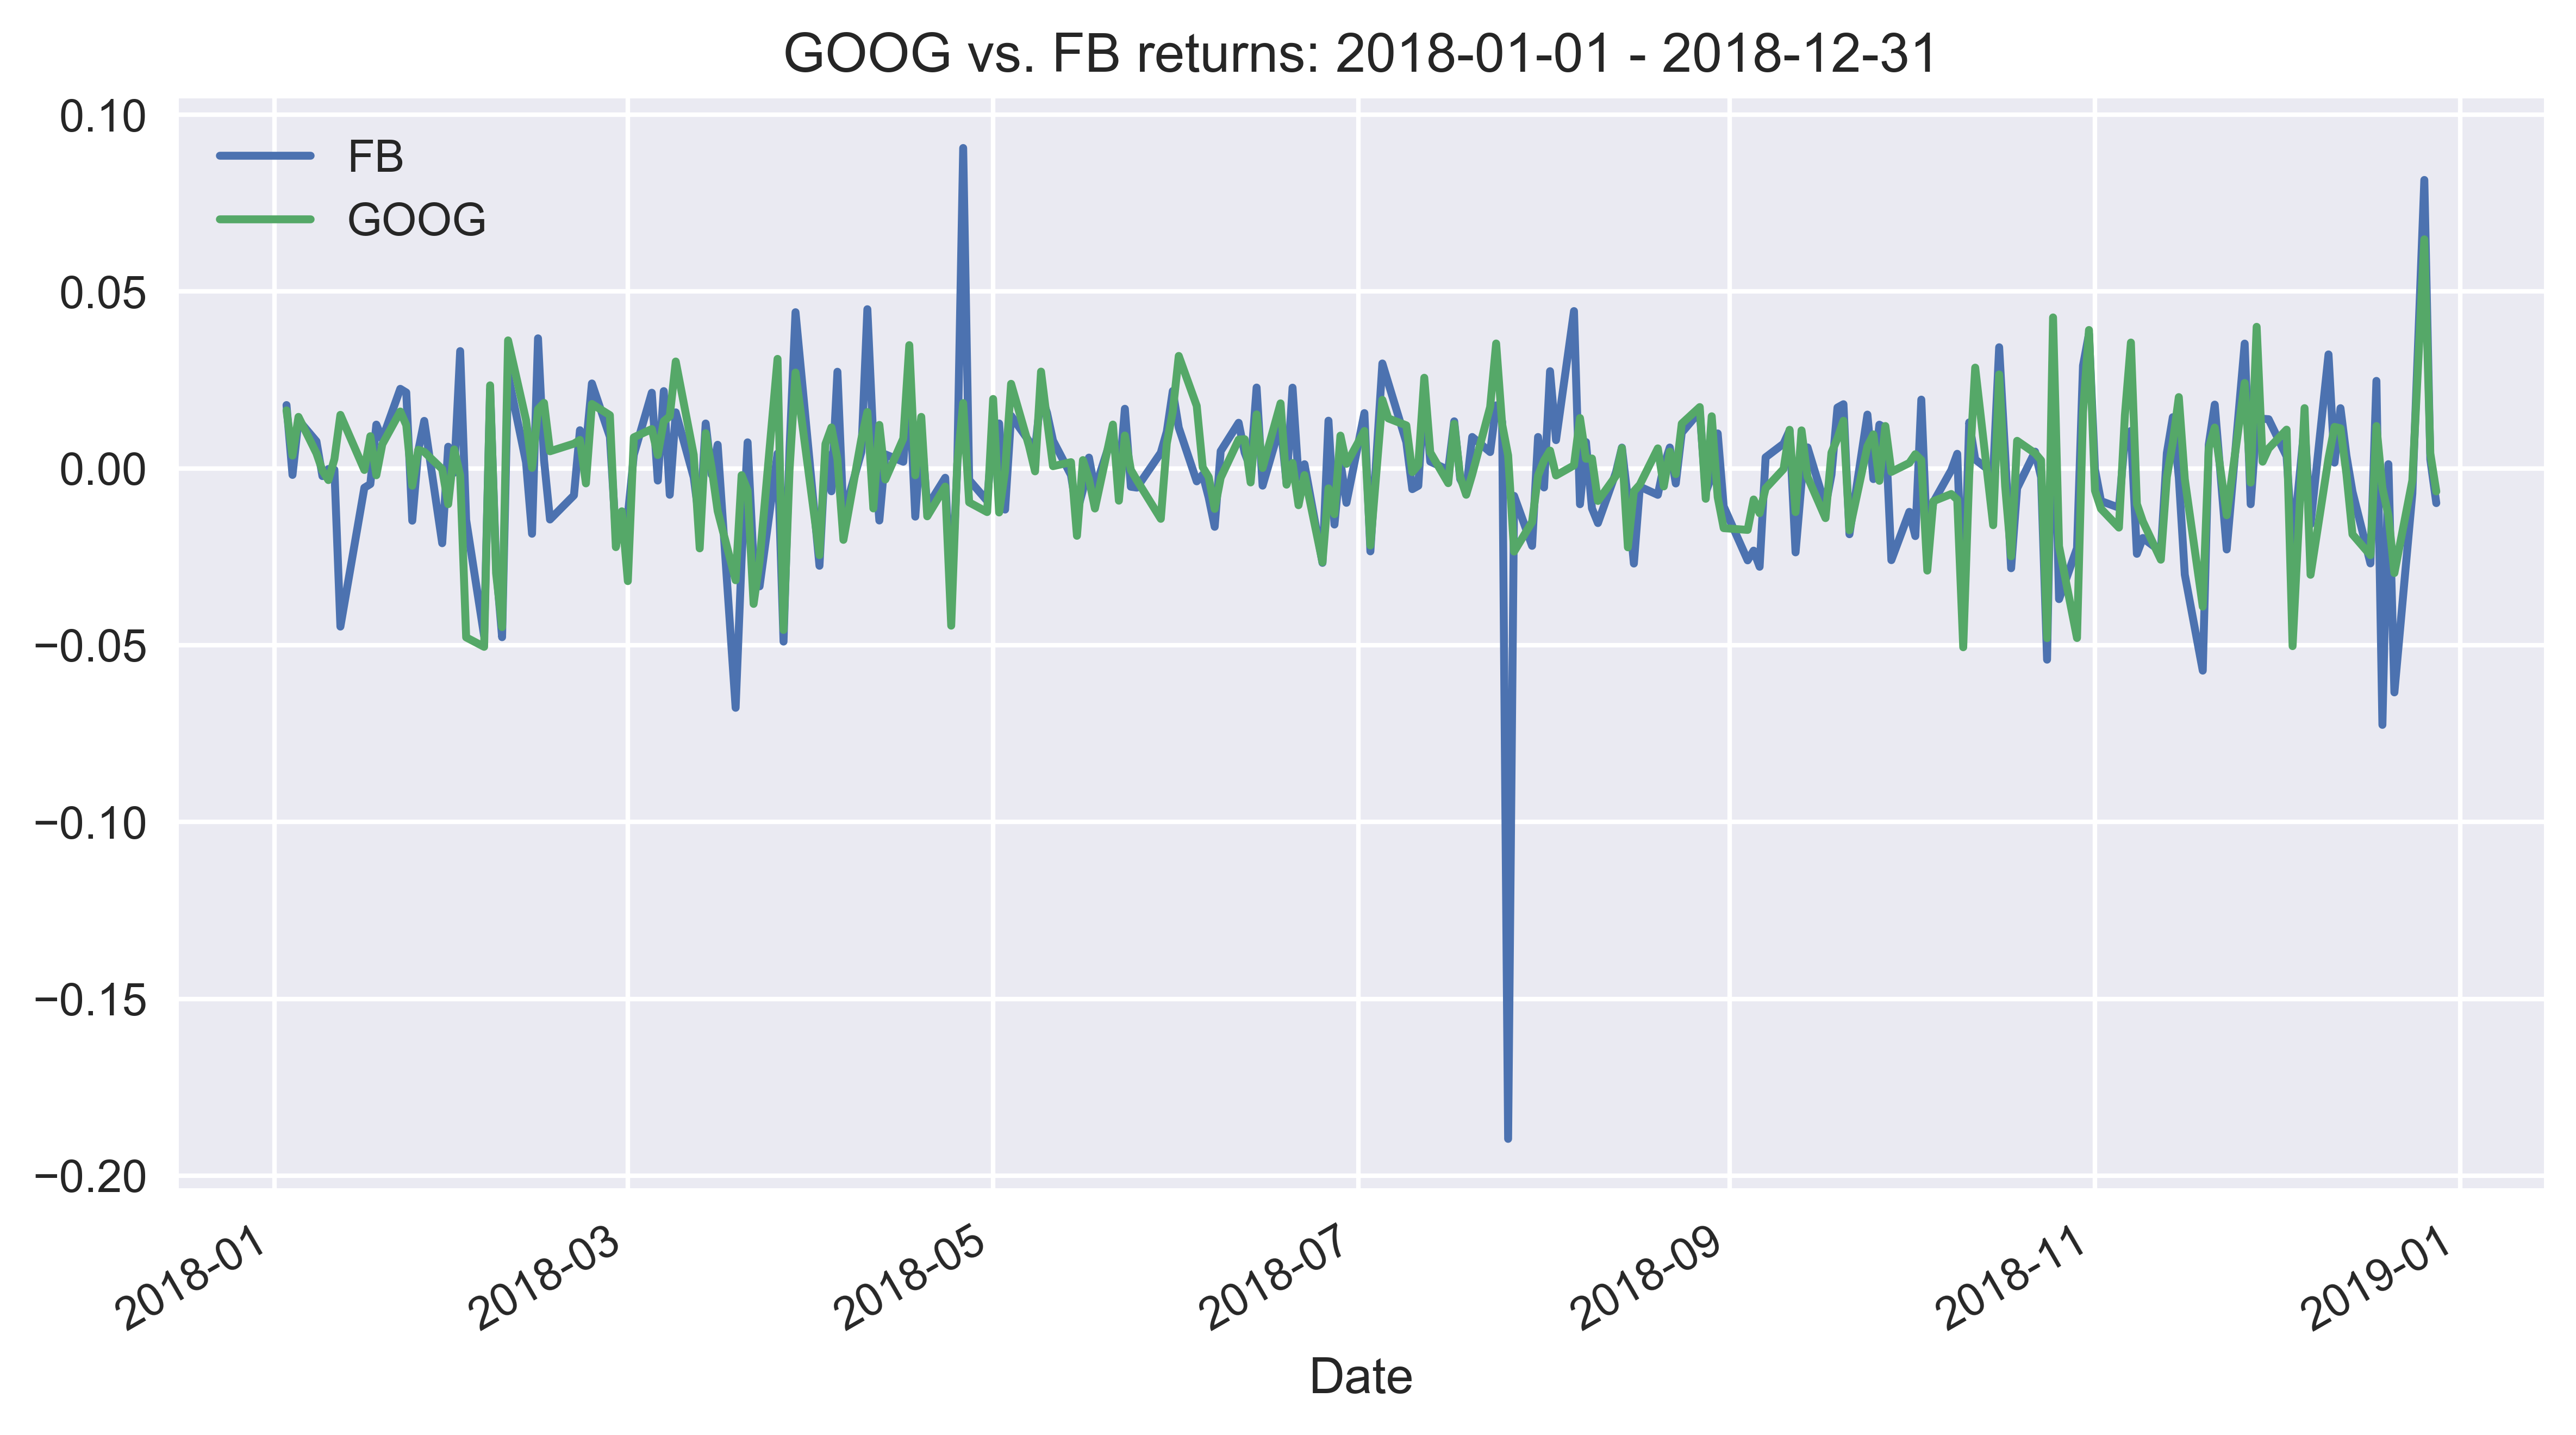

Correlation between returns: 0.62


In [30]:
# 5. Calcular los rendimientos diarios

adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()
plot_title = f'{" vs. ".join(RISKY_ASSETS)} returns: {START_DATE} - {END_DATE}'
returns.plot(title=plot_title)

plt.tight_layout()
plt.show()

print(f'Correlation between returns: {returns.corr().values[0,1]:.2f}')


In [31]:
# 6. Calcule la matriz de covarianza

cov_mat = returns.cov()
cov_mat

FB      GOOG
FB    0.000575  0.000265
GOOG  0.000265  0.000315

In [32]:
# 7. Realice la descomposición de Cholesky de la matriz de covarianza:

chol_mat = np.linalg.cholesky(cov_mat)
chol_mat

array([[0.02397822, 0.        ],
       [0.01105641, 0.01389752]])

In [33]:
# 8. Dibuje números aleatorios correlacionados de la distribución Normal estándar

rv = np.random.normal(size=(N_SIMS, len(RISKY_ASSETS)))
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

In [34]:
# 9. Defina las métricas que se usarán para las simulaciones

r = np.mean(returns, axis=0).values
sigma = np.std(returns, axis=0).values
S_0 = adj_close.values[-1, :]
P_0 = np.sum(SHARES * S_0)

In [35]:
# 10. Calcule el precio terminal de las acciones consideradas

S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + 
                   sigma * np.sqrt(T) * correlated_rv)

In [36]:
#11. Calcule el valor final y los rendimientos del portafolio

P_T = np.sum(SHARES * S_T, axis=1)
P_diff = P_T - P_0

In [37]:
# 12. Calcule el VaR para los niveles de confianza seleccionados

P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f'1-day VaR with {100-x}% confidence: {-y:.2f}$')

1-day VaR with 99.99% confidence: 8.24$
1-day VaR with 99.9% confidence: 7.14$
1-day VaR with 99.0% confidence: 5.78$


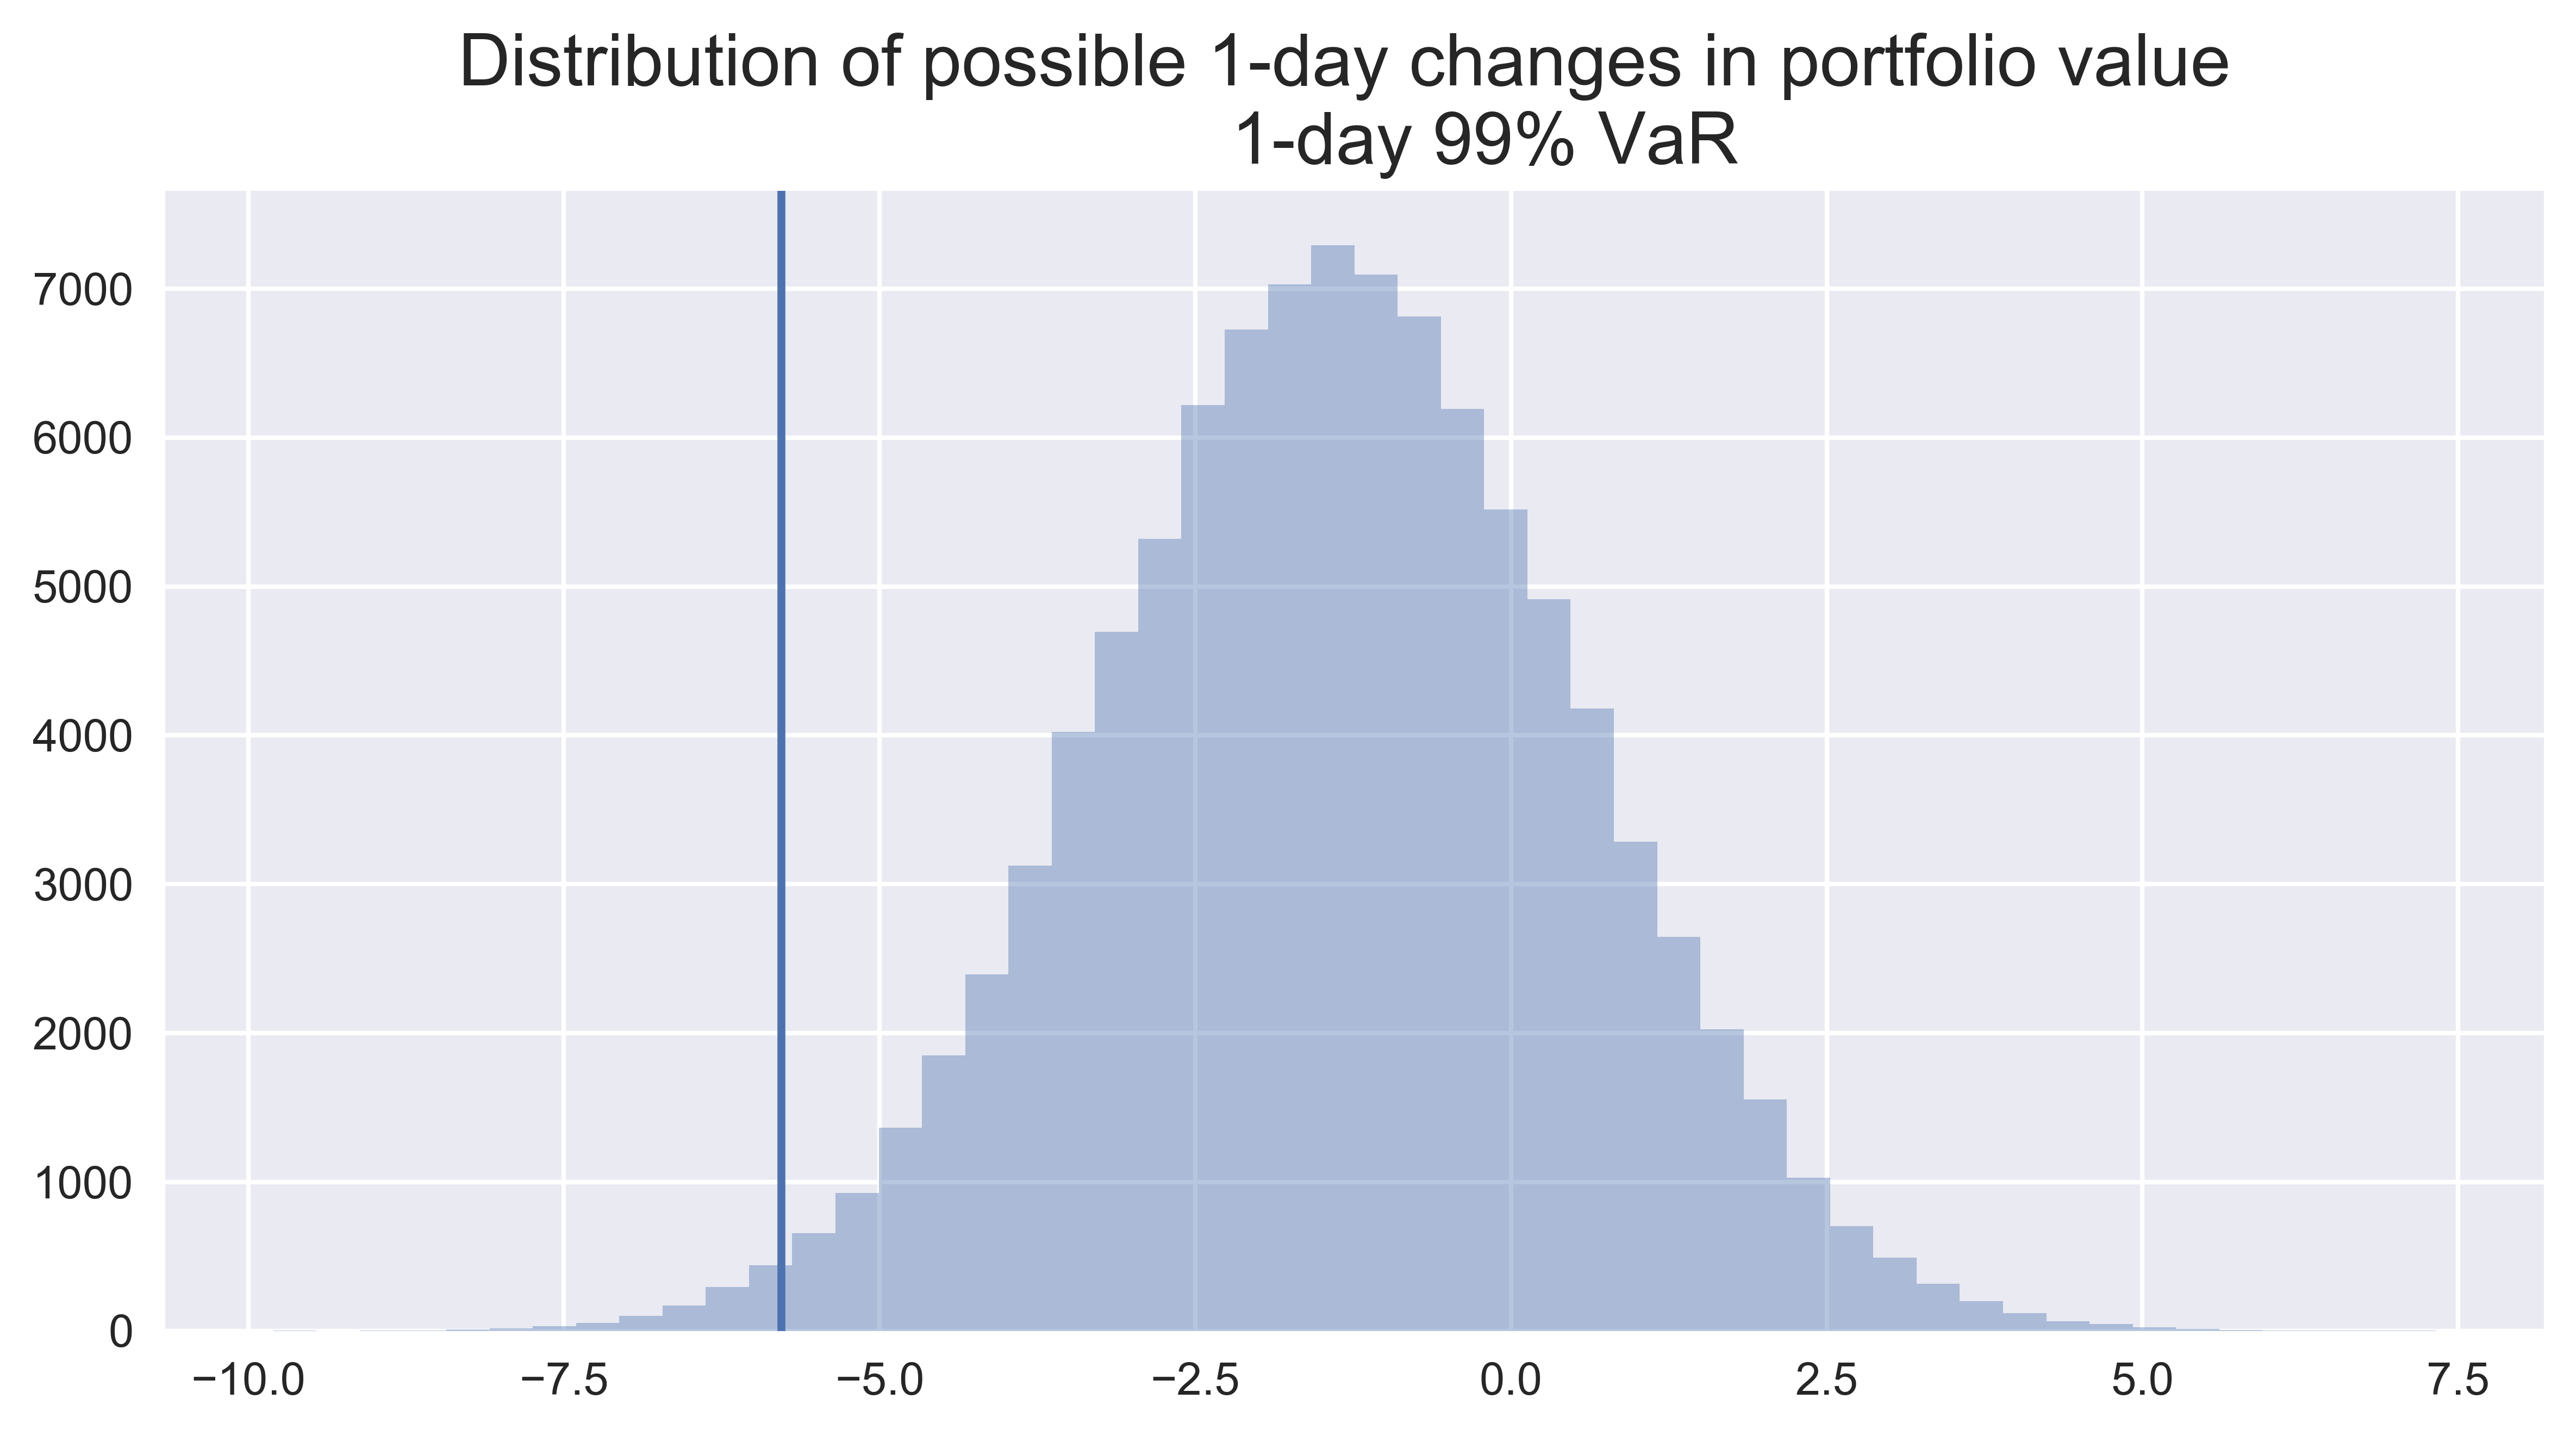

In [39]:
# 13. Presente los resultados en un gráfico 

ax = sns.distplot(P_diff, kde=False)
ax.set_title('''Distribution of possible 1-day changes in portfolio value 
             1-day 99% VaR''', fontsize=16)
ax.axvline(var[2], 0, 10000)

plt.tight_layout()

plt.show()

In [40]:
var = np.percentile(P_diff_sorted, 5)
expected_shortfall = P_diff_sorted[P_diff_sorted<=var].mean()

print(f'The 1-day 95% VaR is {-var:.2f}$, and the accompanying Expected Shortfall is {-expected_shortfall:.2f}$.')

The 1-day 95% VaR is 4.48$, and the accompanying Expected Shortfall is 5.27$.
